In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [5]:
# read training data using pandas

In [7]:
train_data = pd.read_csv("./train.csv")

In [8]:
test_data = pd.read_csv("./test.csv")

In [9]:
print("train_data({0[0]},{0[1]})".format(train_data.shape))
print (train_data.head())

train_data(42000,785)
   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8  pixel9  pixel10  pixel11  pixel12  pixel13  pixel14  pixel15  \
0       0       0        0        0        0        0        0        0   
1       0       0        0        0        0        0        0        0   
2       0       0        0        0        0        0        0        0   
3       0       0        0        0        0        0        0        0   
4       0       0        0        0        0        0        0        0   

   pixel16  pixel17  pixel18      
0        0        0        0 ...  


In [10]:
# Data Processing

In [39]:
train_feature = train_data.iloc[:,1:].values  # split the training data to features and labels
train_label = train_data[[0]].values.ravel()  #numpy.ravel: return a contiguous flattened array.
print("train_feature({0[0]},{0[1]})".format(train_feature.shape))
print("train_label({0})".format(len(train_label)))
print(train_label)

train_feature(42000,784)
train_label(42000)
[1 0 1 ..., 7 6 9]


In [40]:
test_feature = test_data.values
print("test_feature({0[0]},{0[1]})".format(test_feature.shape))

test_feature(28000,784)


In [37]:
# Here we can see both train_feature and test_feature are tensors with a shape of [xxx, 784], however, 
# the train_label is not a tensor. In order to perform the training, we need to convert it to a tensor, 
# which need to convert class labels from scalars to one-hot vectors like:
# 0 => [1 0 0 0 0 0 0 0 0 0]
# 1 => [0 1 0 0 0 0 0 0 0 0]
# .......
# We can use the code from tensorflow website

In [38]:
def dense_to_one_hot(labels_dense, num_classes=10):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

train_label_tensor = dense_to_one_hot(train_label)
train_label_tensor = train_label_tensor.astype(np.uint8)
print("train_label_tensor({0[0]},{0[1]})".format(train_label_tensor.shape))


train_label_tensor(42000,10)


In [41]:
# Now both features and labels are good to go

In [42]:
# Before we proceed to the modeling, let us do a little visulazation work to see the image

In [43]:
# There are totally 42000 training examples, each with 1 label and 784 features. Each feature actually is 28 x 28 
# pixel picture. We can reshape the data.

In [44]:
train_label_reshape = train_label.astype(np.uint8) # uint8 is unsigned integer (0 to 255)
train_feature_reshape = np.array(train_feature).reshape((-1, 1, 28, 28)).astype(np.uint8) # the -1 in reshape (-1,1) means a unspecified value for rows , which here should 42000 
test_feature_reshape = np.array(test_feature).reshape((-1, 1, 28, 28)).astype(np.uint8)

In [45]:
# We can use the matplotlib to plot the digits

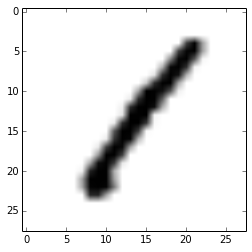

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm

plt.imshow(train_feature_reshape[0][0], cmap=cm.binary)

In [47]:
# Now, let us split the train_data into two parts, one for training (80%, 33600), one for validation (20%, 8400)

In [73]:
# One important step is that we need to normalize the image features 
# # convert from [0, 255] => [0.0, 1.0]

In [74]:
train_feature = np.multiply(train_feature, 1.0/255.0)
test_feature = np.multiply(train_feature, 1.0/255.0)

In [75]:
training_feature = train_feature[:33600]
training_label = train_label_tensor[:33600]

validation_feature = train_feature[33600:]
validation_label = train_label_tensor[33600:]

print("training_feature({0[0]},{0[1]})".format(training_feature.shape))
print("training_label({0[0]},{0[1]})".format(training_label.shape))
print("validation_feature({0[0]},{0[1]})".format(validation_feature.shape))
print("validation_label({0[0]},{0[1]})".format(validation_label.shape))

training_feature(33600,784)
training_label(33600,10)
validation_feature(8400,784)
validation_label(8400,10)


In [76]:
# Next we can run the tensorflow as in the tensorflow tutorial

In [77]:
# First we use the softmax model, which is:
# y=softmax(Wx+b)

In [78]:
import tensorflow as tf

x = tf.placeholder(tf.float32, [None, 784])
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))

In [79]:
# We can now implement our model

In [80]:
y = tf.nn.softmax(tf.matmul(x, W) + b)

In [81]:
# Training step, implement the cross-entropy as cost function

In [82]:
y_ = tf.placeholder(tf.float32, [None, 10])
cross_entropy = -tf.reduce_sum(y_*tf.log(y))

# apply optimization algorithm to modify the variables and reduce the cost
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)
init = tf.initialize_all_variables() # add an operation to initialize the variables we created

In [83]:
# launch the model in a Session, and run the operation that initializes the variables
sess = tf.Session()
sess.run(init) 

In [84]:
# In the follow training, we will use a function next_batch(self, batch_size, fake_data=False), which is defined
# in the tutorail code, I will just copy it (some part I still don't quite understand)

In [85]:
epochs_completed = 0
index_in_epoch = 0
num_examples = training_feature.shape[0]

# serve data by batches
def next_batch(batch_size):

    global training_feature
    global training_label
    global index_in_epoch
    global epochs_completed

    start = index_in_epoch
    index_in_epoch += batch_size
    if index_in_epoch > num_examples:
        # finished epoch
        epochs_completed += 1
        # shuffle the data
        perm = np.arange(num_examples)
        np.random.shuffle(perm)
        training_feature = training_feature[perm]
        training_label = training_label[perm]
        # start next epoch
        start = 0
        index_in_epoch = batch_size
        assert batch_size <= num_examples
    end = index_in_epoch
    return training_feature[start:end], training_label[start:end]

In [86]:
# Then train for 1000 times as in the tutorial
for i in range(1000):
  batch_xs, batch_ys = next_batch(100)
  sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

In [87]:
# Evaluating Our Model
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

In [88]:
# Training accuracy
print(sess.run(accuracy, feed_dict={x: training_feature, y_: training_label}))

0.92253


In [89]:
# Validation accuracy
print(sess.run(accuracy, feed_dict={x: validation_feature, y_: validation_label}))

0.917738
